<a href="https://colab.research.google.com/github/francescoferrini/NLU-SA2-PROJECT/blob/main/NLU_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2-STEP POLARITY REVIEW CLASSIFICATION

##### In this project I'll compute classification of reviews from the nltk movie review dataset. The reviews are labeled into negative and positive. The idea is to divide the problem into 2 different tasks: 
- Subjectivity detection task: from every sentence of the corpus I'll delete the objective sentences
- Classification task: I'll use several machine learning methods to do the classificatin into positive and negative reviews

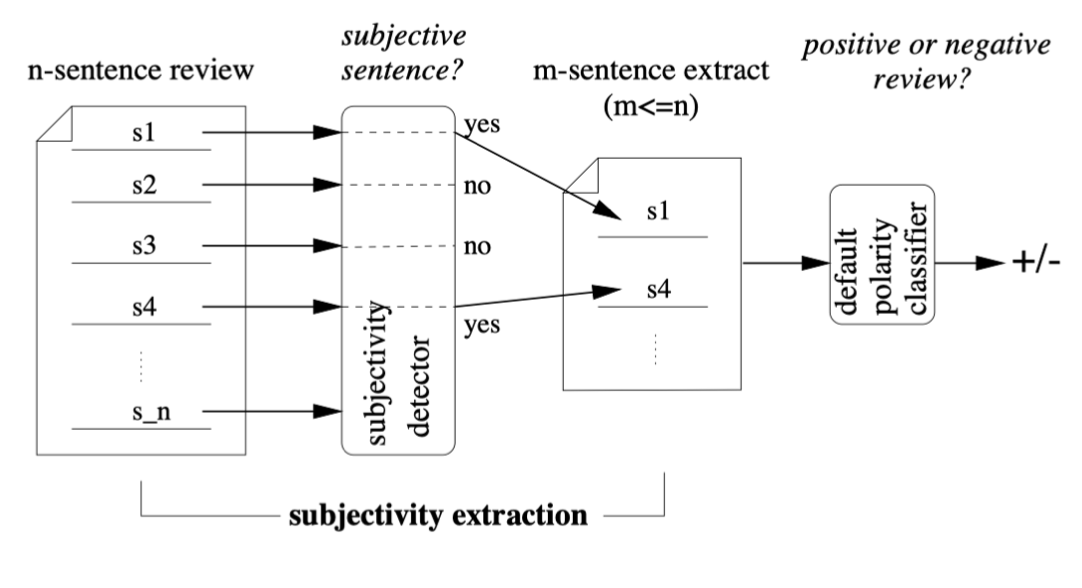

In [40]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Dataset

In [41]:
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [42]:
mr = movie_reviews
neg = mr.paras(categories='neg')
pos = mr.paras(categories='pos')

## 1-STEP: SUBJECTIVITY CLASSIFICATION
##### For this task I decided to try 2 different approaches in order to find and delete the objective sentences:
- TextBlob: a Python  library for processing textual data
- LSTM Neural network

### TextBlob

In [43]:
from textblob import TextBlob
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### The subjectivityCorpusTextBlob function is used to keep only the sentences that have a subjectivity coefficient greater or equal of a certain value using TextBlob

In [44]:
def subjectivityCorpusTextBlob(pos, neg):
  corpus = []
  for i in range(0, len(neg)):
    new_sentence = ''
    sentence_list = [' '.join(i) for i in neg[i]]

    for sentence in sentence_list:
      text = TextBlob(sentence)
      if text.subjectivity >= 0.4:
        new_sentence = new_sentence+sentence
    corpus.append(new_sentence)

  for i in range(0, len(pos)):
    new_sentence = ''
    sentence_list = [' '.join(i) for i in pos[i]]

    for sentence in sentence_list:
      text = TextBlob(sentence)
      if text.subjectivity >= 0.4:
        new_sentence = new_sentence+sentence
    corpus.append(new_sentence)
  return corpus

textblob_corpus = subjectivityCorpusTextBlob(pos, neg)

### LSTM
##### For the training of the Network I used the  [subjectivity dataset](https://www.cs.cornell.edu/people/pabo/movie-review-data/) from stanford

####Downloading of GoogleNews-vectors-negative300.bin


In [45]:
#cd /content/gdrive/MyDrive/AIS_Projects/NLU

In [46]:
#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#!gzip -d GoogleNews-vectors-negative300.bin.gz

#### Creation of the dataframe used for the Network:
- polarity = 1 means subjective sentence
- polarity = 0 means objective sentence


In [47]:
import pandas as pd
df_subj = pd.read_csv('/content/gdrive/MyDrive/AIS_Projects/NLU/data/quote.tok.gt9.5000', sep='\n', encoding='latin-1', names=['text'])
df_obj = pd.read_csv('/content/gdrive/MyDrive/AIS_Projects/NLU/data/plot.tok.gt9.5000', sep='\n', encoding='latin-1', names=['text'])

In [48]:
pol = []
for i in range(0, len(df_subj)):
  pol.append(1)
df_subj['polarity'] = pol

pol = []
for i in range(0, len(df_obj)):
  pol.append(0)
df_obj['polarity'] = pol

In [49]:
frames = [df_subj, df_obj]
result = pd.concat(frames)
df = result.sample(frac=1).reset_index(drop=True)
df.head(10)

,text,polarity
0,it is just too bad the film's story does not l...,1
1,it's a terrific american sports movie and denn...,1
2,"en un ca&#243 ; tico principio del siglo xxi ,...",0
3,"together with his men , mcnamara uses a hero's...",0
4,"like mike is a winner for kids , and no doubt ...",1
5,"matsumoto and sawako were a happy couple , but...",0
6,"it's like rocky and bullwinkle on speed , but ...",1
7,"mary is an 18-year-old high school senior , an...",0
8,it's that rare family movie -- genuine and swe...,1
9,"hey , happy ! is great for stoners , queens , ...",1


In [50]:
df.describe()

,polarity
count,10000.000000
mean,0.500000
std,0.500025
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


### Splitting the dataset into train and test.

In [51]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Embedding, LSTM
from keras import Input
from keras.preprocessing import text,sequence

from gensim.models.word2vec import Word2Vec


from gensim.models.keyedvectors import KeyedVectors
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model

In [52]:
from sklearn.model_selection import train_test_split


df.count()


df.drop_duplicates(subset ="text", keep = 'first', inplace = True) 
df.count()

x = df['text'].apply(str).values
y = df['polarity'].values
SEED = 2000

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.1, random_state=SEED)

print ("Train set has total {0} entries with {1:.2f}% objective, {2:.2f}% subjective".format(len(x_train),(len(x_train[y_train == 0]) / (len(x_train)*1.))*100,(len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% objective, {2:.2f}% subjective".format(len(x_test),(len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 9000 entries with 50.07% objective, 49.93% subjective
Test set has total 1000 entries with 49.40% objective, 50.60% subjective


### Tokenization of text using keras

In [53]:
tk = text.Tokenizer(num_words=200, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True, split=" ")
tk.fit_on_texts(x_train)
sequences_train = tk.texts_to_sequences(x_train)
sequences_test = tk.texts_to_sequences(x_test)
word_index = tk.word_index
print('Found %s unique tokens.' % len(word_index))

Found 20006 unique tokens.


###Padding sequences with pad_sequences from keras (This function transforms a list of sequences (lists of integers) into a 2D Numpy array)

In [54]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(sequences_train, maxlen=200)
x_test = pad_sequences(sequences_test , maxlen=200)

### Load GoogleNews-vectors-negative300.bin for word2vec encoding

In [55]:
w2v = KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/AIS_Projects/NLU/GoogleNews-vectors-negative300.bin', binary=True, limit=500000)
print('Google News w2v loaded')

w2v_matrix = np.zeros((len(word_index) + 1, 300))

for word,i in word_index.items():
    if word in w2v.vocab:
        w2v_matrix[i] = w2v[word]

Google News w2v loaded


### Model creation

In [56]:
model = Sequential()
model.add(Embedding(len(word_index)+1, w2v_matrix.shape[1], weights=[w2v_matrix], input_length=200))
model.add(LSTM(units=70))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('relu'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
plot_model(model, to_file="Word2Vec300.png", show_shapes=True)

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
mc = ModelCheckpoint('Word2Vec_LSTM.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, 
                    epochs=200,
                    callbacks=[es, mc],
                    validation_data=(x_test, y_test))

import tensorflow as tf

model = tf.keras.models.load_model('Word2Vec_LSTM.h5')


loss, accuracy = model.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)
print('Model Loss: {:0.4f} | Model Accuracy: {:.4f}'.format(loss, accuracy))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          6002100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                103880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 71        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 6,106,051
Trainable params: 6,106,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
282/282 [==============================] - 87s 301ms/step - loss: 0.6012 - accuracy: 0.7596 - val_

### Making predictions and plotting the confusion matrix

In [57]:
predictions = model.predict(x=x_test, batch_size=32)

predictions = [0 if i<0.5 else 1 for i in predictions]

from sklearn.metrics import classification_report
print("Classification Report: \n",classification_report(y_test, predictions))

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       494
           1       0.86      0.84      0.85       506

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



### Creation of the corpus: keeping only the sentences with a score greater than 0.4

In [58]:
lstm_corpus = []
for i in range(0, len(neg)):
    sentence_list = [' '.join(i) for i in neg[i]]
    new_sentence = ''

    #use the model
    new_sequences_test = tk.texts_to_sequences(sentence_list)
    new_x_test = pad_sequences(new_sequences_test , maxlen=200)
    predictions = model.predict(x=new_x_test, batch_size=32)

    for sentence, pred in zip(sentence_list, predictions):
      if (pred > 0.4):
        new_sentence = new_sentence + sentence
    lstm_corpus.append(new_sentence)

for i in range(0, len(pos)):
    sentence_list = [' '.join(i) for i in pos[i]]
    new_sentence = ''

    #use the model
    new_sequences_test = tk.texts_to_sequences(sentence_list)
    new_x_test = pad_sequences(new_sequences_test , maxlen=200)
    predictions = model.predict(x=new_x_test, batch_size=32)

    for sentence, pred in zip(sentence_list, predictions):
      if (pred > 0.4):
        new_sentence = new_sentence + sentence
    lstm_corpus.append(new_sentence)

## STEP 2: CLASSIFICATION
##### For this task I tried several machine learning techniques like Logistic Regression, Linear Support Vector Machines, Ranfom Forest and Multilayer Perceptron

In [59]:
import numpy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report

from nltk.corpus import movie_reviews
nltk.download('punkt')
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


###Labeling sentiment

In [60]:
labels = numpy.array([0] * len(neg) + [1] * len(pos))

###Creation of Bag of words model

In [61]:
cv=CountVectorizer()
BOW_vectors_textblob = cv.fit_transform(textblob_corpus)
BOW_vectors_lstm = cv.fit_transform(lstm_corpus)

###Creation of TF-IDF model

In [62]:
tv=TfidfVectorizer()
TFIDF_vectors_textblob = tv.fit_transform(textblob_corpus)
TFIDF_vectors_lstm = tv.fit_transform(lstm_corpus)

### Classifiers


####Logistic Regression

In [63]:
classifier = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

In [64]:
BOW_scores_dict = {}
TFIDF_scores_dict = {}

scores = cross_validate(classifier, BOW_vectors_textblob, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
BOW_scores_dict['BOW vector, textblob corpus'] = round(average, 3)

scores = cross_validate(classifier, BOW_vectors_lstm, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
BOW_scores_dict['BOW vector, lstm corpus'] = round(average, 3)

scores = cross_validate(classifier, TFIDF_vectors_textblob, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
TFIDF_scores_dict['TFIDF vector, textblob corpus'] = round(average, 3)

scores = cross_validate(classifier, TFIDF_vectors_lstm, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
TFIDF_scores_dict['TFIDF vector, lstm corpus'] = round(average, 3)

print(BOW_scores_dict)
print(TFIDF_scores_dict)

{'BOW vector, textblob corpus': 0.838, 'BOW vector, lstm corpus': 0.832}
{'TFIDF vector, textblob corpus': 0.838, 'TFIDF vector, lstm corpus': 0.844}


####Naive Bayes


In [65]:
classifier = MultinomialNB()

In [66]:
BOW_scores_dict = {}
TFIDF_scores_dict = {}

scores = cross_validate(classifier, BOW_vectors_textblob, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
BOW_scores_dict['BOW vector, textblob corpus'] = round(average, 3)

scores = cross_validate(classifier, BOW_vectors_lstm, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
BOW_scores_dict['BOW vector, lstm corpus'] = round(average, 3)

scores = cross_validate(classifier, TFIDF_vectors_textblob, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
TFIDF_scores_dict['TFIDF vector, textblob corpus'] = round(average, 3)

scores = cross_validate(classifier, TFIDF_vectors_lstm, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
TFIDF_scores_dict['TFIDF vector, lstm corpus'] = round(average, 3)

print(BOW_scores_dict)
print(TFIDF_scores_dict)

{'BOW vector, textblob corpus': 0.825, 'BOW vector, lstm corpus': 0.834}
{'TFIDF vector, textblob corpus': 0.831, 'TFIDF vector, lstm corpus': 0.818}


####LinearSVM

In [67]:
classifier = LinearSVC()

In [68]:
BOW_scores_dict = {}
TFIDF_scores_dict = {}

scores = cross_validate(classifier, BOW_vectors_textblob, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
BOW_scores_dict['BOW vector, textblob corpus'] = round(average, 3)

scores = cross_validate(classifier, BOW_vectors_lstm, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
BOW_scores_dict['BOW vector, lstm corpus'] = round(average, 3)

scores = cross_validate(classifier, TFIDF_vectors_textblob, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
TFIDF_scores_dict['TFIDF vector, textblob corpus'] = round(average, 3)

scores = cross_validate(classifier, TFIDF_vectors_lstm, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
TFIDF_scores_dict['TFIDF vector, lstm corpus'] = round(average, 3)

print(BOW_scores_dict)
print(TFIDF_scores_dict)

{'BOW vector, textblob corpus': 0.822, 'BOW vector, lstm corpus': 0.827}
{'TFIDF vector, textblob corpus': 0.855, 'TFIDF vector, lstm corpus': 0.86}


####Random Forest

In [69]:
classifier = RandomForestClassifier(n_estimators=100)

In [70]:
BOW_scores_dict = {}
TFIDF_scores_dict = {}

scores = cross_validate(classifier, BOW_vectors_textblob, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
BOW_scores_dict['BOW vector, textblob corpus'] = round(average, 3)

scores = cross_validate(classifier, BOW_vectors_lstm, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
BOW_scores_dict['BOW vector, lstm corpus'] = round(average, 3)

scores = cross_validate(classifier, TFIDF_vectors_textblob, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
TFIDF_scores_dict['TFIDF vector, textblob corpus'] = round(average, 3)

scores = cross_validate(classifier, TFIDF_vectors_lstm, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
TFIDF_scores_dict['TFIDF vector, lstm corpus'] = round(average, 3)

print(BOW_scores_dict)
print(TFIDF_scores_dict)

{'BOW vector, textblob corpus': 0.774, 'BOW vector, lstm corpus': 0.812}
{'TFIDF vector, textblob corpus': 0.784, 'TFIDF vector, lstm corpus': 0.806}


####MLP

In [71]:
classifier = MLPClassifier(alpha=1e-05)

In [72]:
BOW_scores_dict = {}
TFIDF_scores_dict = {}

scores = cross_validate(classifier, BOW_vectors_textblob, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
BOW_scores_dict['BOW vector, textblob corpus'] = round(average, 3)

scores = cross_validate(classifier, BOW_vectors_lstm, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
BOW_scores_dict['BOW vector, lstm corpus'] = round(average, 3)

scores = cross_validate(classifier, TFIDF_vectors_textlob, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
TFIDF_scores_dict['TFIDF vector, textblob corpus'] = round(average, 3)

scores = cross_validate(classifier, TFIDF_vectors_lstm, labels, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
TFIDF_scores_dict['TFIDF vector, lstm corpus'] = round(average, 3)

print(BOW_scores_dict)
print(TFIDF_scores_dict)

{'BOW vector, textblob corpus': 0.843, 'BOW vector, lstm corpus': 0.861}
{'TFIDF vector, textblob corpus': 0.853, 'TFIDF vector, lstm corpus': 0.863}
